# This notebook is for The final project of CS degree

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import random
import os
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading data for left to back transformation
- Going to give 80% training and 20% test

In [ ]:

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),       # Resize the images to a fixed size
    transforms.Grayscale(),               # Convert images to grayscale
    transforms.ToTensor()                  # Convert images to tensors
])

# Set the paths to your folders containing the images
folder1_path = "/content/drive/MyDrive/final_project_data/Posture/Left_Reg"
folder2_path = "/content/drive/MyDrive/final_project_data/Posture/Back_Reg"
# Create custom dataset class for paired images
class PairedImageDataset(Dataset):
    def __init__(self, folder1_path, folder2_path, transform=None):
        self.folder1_dataset = ImageFolder(folder1_path, transform=transform)
        self.folder2_dataset = ImageFolder(folder2_path, transform=transform)
        self.transform = transform

    def __getitem__(self, index):
        img1, _ = self.folder1_dataset[index]
        img2, _ = self.folder2_dataset[index]
        return img1, img2

    def __len__(self):
        return max(len(self.folder1_dataset), len(self.folder2_dataset))

# Create the paired dataset
paired_dataset = PairedImageDataset(folder1_path, folder2_path, transform=transform)
train_set,test_set = torch.utils.data.random_split(paired_dataset,[0.8,0.2])
# Create the train_loader
batch_size = 1   # Set your desired batch size
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_loader))
print(len(test_loader))

130
32


In [ ]:
left,back = next(iter(train_loader))
print(left.shape)
print(back.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


- Function to transform affine parameters to an affine matrix for affine grid

In [ ]:
def affine2matrix(angle, translation, scale, shear):
    """
    Create an affine transformation matrix given the transformation parameters.

    Args:
        angle: Rotation angle in degrees.
        translation: Horizontal and vertical translation as a 1D tensor of shape (batch_size, 2).
        scale: Scale factor as a 1D tensor of shape (batch_size,).
        shear: Shear angle in degrees.

    Returns:
        Affine transformation matrix of shape (batch_size, 2, 3).
    """
    angle_rad = torch.deg2rad(angle)
    shear_rad = torch.deg2rad(shear)

    cos_theta = torch.cos(angle_rad)
    sin_theta = torch.sin(angle_rad)
    shear_factor = torch.tan(shear_rad)

    batch_size = angle.size(0)

    # Create the 2x2 rotation matrix
    rotation_matrix = torch.zeros(batch_size, 2, 2, device=angle.device)
    rotation_matrix[:, 0, 0] = cos_theta
    rotation_matrix[:, 0, 1] = -sin_theta
    rotation_matrix[:, 1, 0] = sin_theta
    rotation_matrix[:, 1, 1] = cos_theta

    # Create the 2x3 shear matrix
    shear_matrix = torch.zeros(batch_size, 2, 3, device=angle.device)
    shear_matrix[:, 0, 0] = 1.0
    shear_matrix[:, 0, 1] = shear_factor
    shear_matrix[:, 1, 0] = 0.0
    shear_matrix[:, 1, 1] = 1.0

    # Create the 2x3 translation matrix
    translation_matrix = torch.zeros(batch_size, 2, 3, device=angle.device)
    translation_matrix[:, 0, 0] = 1.0
    translation_matrix[:, 0, 2] = translation[:, 0]
    translation_matrix[:, 1, 1] = 1.0
    translation_matrix[:, 1, 2] = translation[:, 1]

    # Create the 2x3 scale matrix
    scale_matrix = torch.zeros(batch_size, 2, 3, device=angle.device)
    scale_matrix[:, 0, 0] = scale
    scale_matrix[:, 1, 1] = scale
    first_mult = torch.matmul(rotation_matrix, shear_matrix)
    second_mult = torch.matmul(torch.transpose(shear_matrix,1,2), translation_matrix)

    # Combine all matrices to get the final affine transformation matrix
    affine_matrix = torch.matmul(first_mult,second_mult)

    return affine_matrix

#### The Model
- This is the model we will use for the affine transformation
- We train on both the transformation and also the output image

In [ ]:
class AffineCNN(nn.Module):
    def __init__(self):
        super(AffineCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 16  * 16, 128*4),
            nn.ReLU(inplace=True),
            nn.Linear(128*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 5)
            # 5-dimensional transformation parameters (rotation in radians,horizontal translation,vertical translation,scale,sheer in radians)
        )
        self.affine = None

    def forward(self, image):
        output = self.cnn(image)
        output = output.view(output.size(0), -1)
        out = self.fc(output)
        angle = torch.rad2deg(out[:, 0])  # Rotation in degrees
        translation = out[:, 1:3]  # Horizontal and vertical translation
        scale = torch.abs(out[:, 3])  # Scale
        shear = torch.rad2deg(out[:, 4])  # Shear in degrees

        # Create the 2x3 affine transformation matrix
        affine_matrix = affine2matrix(angle, translation, scale, shear)
        self.affine = affine_matrix
        # Apply the affine transformation using grid_sample
        grid = F.affine_grid(affine_matrix[:, :2, :], image.size())
        out_image = F.grid_sample(image, grid,align_corners=False)
        return out,out_image

- Functions to measure Quality of transformed images

In [ ]:
def mean_squared_error(y_true, y_pred):
    """
    Compute Mean Squared Error (MSE).

    Parameters:
    y_true (numpy array): Array of true values.
    y_pred (numpy array): Array of predicted values.

    Returns:
    float: Mean Squared Error.
    """
    return np.mean((y_true - y_pred) ** 2)
def normalized_cross_correlation(signal1, signal2):
    """
    Compute Normalized Cross-Correlation (NCC) between two signals.

    Parameters:
    signal1 (numpy array): First signal.
    signal2 (numpy array): Second signal.

    Returns:
    float: Normalized Cross-Correlation.
    """

    # Ensure the input signals have the same length
    if len(signal1) != len(signal2):
        raise ValueError("Both signals must have the same length.")

    # Compute mean of the signals
    mean_signal1 = np.mean(signal1)
    mean_signal2 = np.mean(signal2)

    # Compute the cross-correlation term
    cross_corr = np.sum((signal1 - mean_signal1) * (signal2 - mean_signal2))

    # Compute the denominator for normalization
    denom = np.sqrt(np.sum((signal1 - mean_signal1) ** 2) * np.sum((signal2 - mean_signal2) ** 2))

    # Avoid division by zero
    if denom == 0:
        return 0.0

    # Compute the normalized cross-correlation
    ncc = cross_corr / denom
    return ncc

In [ ]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)
  elif classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data,0,0.03)

- Initialize weights, net and see summary of it

In [ ]:
net_left = AffineCNN()
net_left.apply(weight_init)
left,back = next(iter(train_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_left = net_left.to(device)
left = left.to(device)
summary(net_left, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


### Training Loop
- The main training loop for the model, in this loop, we create a fixed transformation that is suppsed to look like what we are looking for, but not exectly, and then train it with the transformation according to the net, And also with the image that it produces in some probability

In [ ]:
def train(opt,model,trainloader,crit,num_epoch,device):
  loss = []

  start_time = time.time()
  model = model.to(device)
  count_reg = 0
  count_fake = 0
  for epoch in range(num_epoch):
    counter = 0
    for left,back in trainloader:
      # Move images to device
      left = left.to(device)
      back = back.to(device)

      # Random number to know if train on a real or fake image
      coin = torch.randint(4,(1,)).item()

      # Create target basic transformation
      target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
      target = target.to(device)
      target = torch.reshape(target,(1,5))

      # Zero gradient to learn
      model.zero_grad()
      transformation,image = model(left)

      if coin == 0:# use fake back
        count_fake+=1
        error = crit(transformation,target)
        error += crit(image,back)
      else:# use real back
        error = crit(image,back)
        count_reg+=1

      error.backward()
      opt.step()

      if counter % 30 == 0:
        loss.append(error.item())
        time_from_start = time.time()-start_time
        mins = time_from_start // 60
        seconds = time_from_start % 60
        print(f"[{int(mins)}m, {seconds:.4f}s][{epoch+1}/{num_epoch}] [{counter+1}/{len(train_loader)}] Loss = {error:.4f}")
        print(f"fake tries: {count_fake} percentage = {count_fake/(count_fake+count_reg):.4f}, real tries:{count_reg} percentage:{count_reg/(count_fake+count_reg):.4f}, ratio real/fake = {count_reg/(count_fake+1e-7):.4f}")
      counter +=1
  print(f"fake tries: {count_fake} percentage = {count_fake/(count_fake+count_reg+1e-7):.4f}, real tries:{count_reg} percentage:{count_reg/(count_fake+count_reg++1e-7):.4f}, ratio real/fake = {count_reg/(count_fake+1e-7):.4f}")
  return loss

In [ ]:
opt = optim.SGD(net_left.parameters(),lr=0.005)
criterion = nn.MSELoss()

# Start the process for left to back transformation

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])


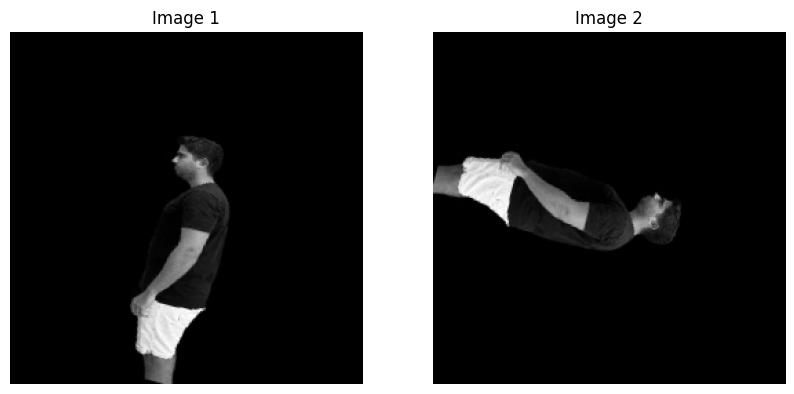

In [ ]:
left,back = next(iter(train_loader))
# var_tran = torch.randint(0,30,(1,)).item()
# hor_tran = torch.randint(0,30,(1,)).item()
# scale = torch.rand((1,)).item() * 3
# sheer = torch.rand((1,)).item() *3
back = transforms.functional.affine(left,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(left.squeeze(),cmap="gray")
axes[0].set_title('Image 1')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(back.squeeze(),cmap="gray")
axes[1].set_title('Image 2')
axes[1].axis('off')

# Show the plot
plt.show()

In [ ]:
loss = train(opt,net_left,train_loader,criterion,100,device)

, 0.0198s][1/100] [1/130] Loss = 0.6797
fake tries: 1 percentage = 1.0000, real tries:0 percentage:0.0000, ratio real/fake = 0.0000
, 0.5366s][1/100] [31/130] Loss = 0.0531
fake tries: 9 percentage = 0.2903, real tries:22 percentage:0.7097, ratio real/fake = 2.4444
, 1.0035s][1/100] [61/130] Loss = 0.0204
fake tries: 19 percentage = 0.3115, real tries:42 percentage:0.6885, ratio real/fake = 2.2105
, 1.4535s][1/100] [91/130] Loss = 0.6446
fake tries: 27 percentage = 0.2967, real tries:64 percentage:0.7033, ratio real/fake = 2.3704
, 1.7692s][1/100] [121/130] Loss = 0.0604
fake tries: 36 percentage = 0.2975, real tries:85 percentage:0.7025, ratio real/fake = 2.3611
, 1.9252s][2/100] [1/130] Loss = 0.0234
fake tries: 37 percentage = 0.2824, real tries:94 percentage:0.7176, ratio real/fake = 2.5405
, 2.2848s][2/100] [31/130] Loss = 0.0477
fake tries: 43 percentage = 0.2671, real tries:118 percentage:0.7329, ratio real/fake = 2.7442
, 2.6555s][2/100] [61/130] Loss = 0.0551
fake tries: 51 pe

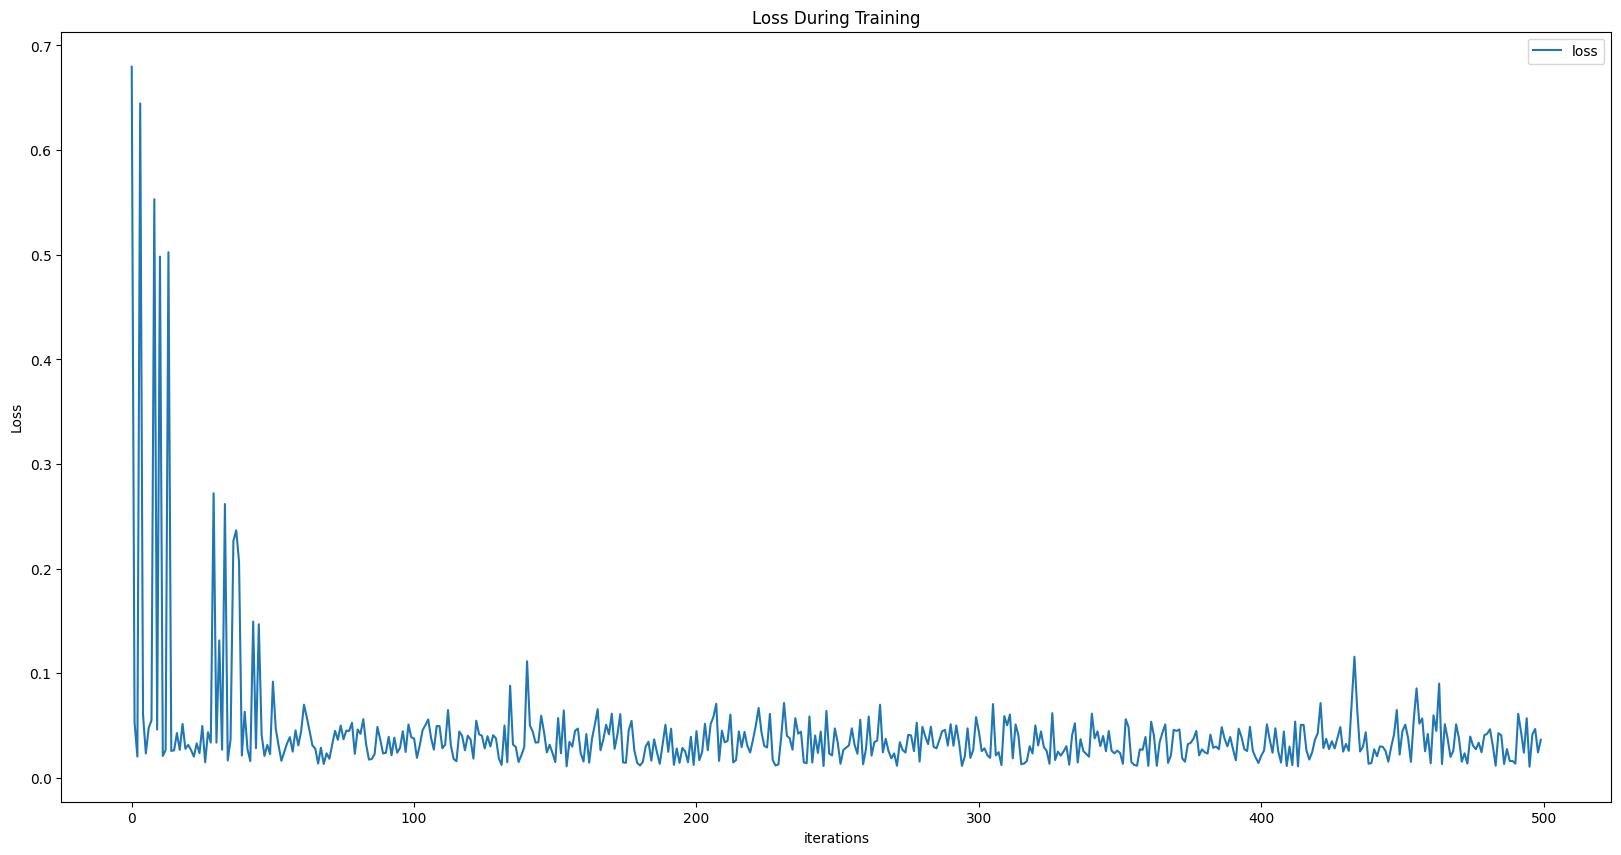

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Loss During Training")
plt.plot(loss,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([[ 1.5239,  0.0786, -0.2538,  0.9985,  0.0106]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
<class 'torch.Tensor'>
[ 1.52389574  0.0786455  -0.25382853  0.99853641  0.01064831]



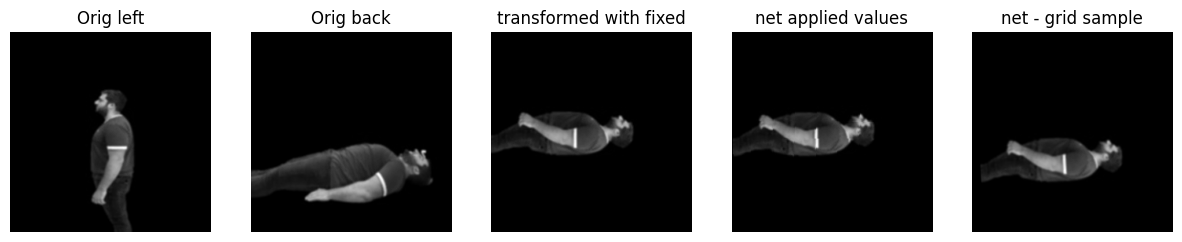

In [ ]:
left,back = next(iter(train_loader))
pic_target = transforms.functional.affine(left,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Display the first image on the left subplot
axes[0].imshow(left.squeeze(),cmap="gray")
axes[0].set_title('Orig left')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(back.squeeze(),cmap="gray")
axes[1].set_title('Orig back')
axes[1].axis('off')

# Show the plot
out = net_left(left.to(device))
print(out[0])
print(type(left))
array = out[0].cpu().detach().numpy()[0].astype('float')
print(array)
print()
out_transform = transforms.functional.affine(left,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))
axes[2].imshow(pic_target.squeeze(),cmap="gray")
axes[2].set_title('transformed with fixed')
axes[2].axis('off')

axes[3].imshow(out_transform.squeeze().cpu().detach().numpy(),cmap="gray")
axes[3].set_title('net applied values')
axes[3].axis('off')

axes[4].imshow(torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy(),cmap="gray")
axes[4].set_title('net - grid sample')
axes[4].axis('off')


plt.show()

In [ ]:
back_np = back.squeeze().cpu().numpy()
fixed_np = pic_target.squeeze().cpu().numpy()
net_np = out_transform.squeeze().cpu().detach().numpy()
grid_np = torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy()
mse_diff_fix = mean_squared_error(back_np,fixed_np)
mse_diff_net = mean_squared_error(back_np,net_np)
mse_diff_grid = mean_squared_error(back_np,grid_np)
ncc_diff_fix = normalized_cross_correlation(back_np,fixed_np)
ncc_diff_net = normalized_cross_correlation(back_np,net_np)
ncc_diff_grid = normalized_cross_correlation(back_np,grid_np)
print("MSE - need lower, NCC - need higher")
print(f"Difference between fixed transformation and back image: MSE = {mse_diff_fix:.5f} NCC = {ncc_diff_fix:.5f}")
print(f"Difference between net transformation and back image: MSE = {mse_diff_net:.5f} NCC = {ncc_diff_net:.5f}")
print(f"Difference between grid transformation and back image: MSE = {mse_diff_grid:.5f} NCC = {ncc_diff_grid:.5f}")

MSE - need lower, NCC - need higher
Difference between fixed transformation and back image: MSE = 0.02242 NCC = -0.06284
Difference between net transformation and back image: MSE = 0.02236 NCC = -0.06145
Difference between grid transformation and back image: MSE = 0.01560 NCC = 0.27060


- Check resuls on random test

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([[ 1.5240,  0.0787, -0.2539,  0.9986,  0.0107]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
<class 'torch.Tensor'>
[ 1.52399874  0.07867339 -0.25385755  0.99860525  0.01065706]



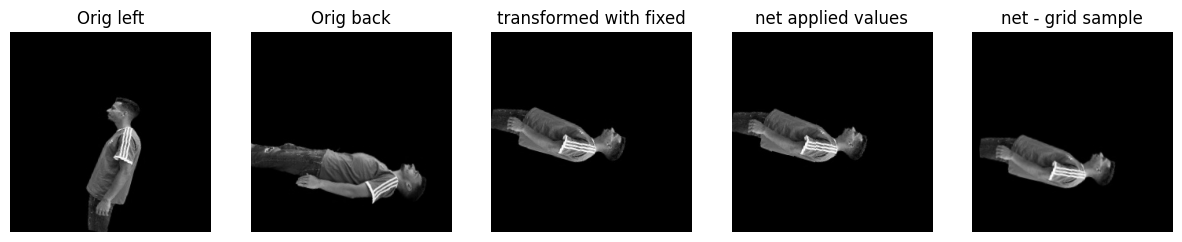

In [ ]:
left,back = next(iter(test_loader))
pic_target = transforms.functional.affine(left,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Display the first image on the left subplot
axes[0].imshow(left.squeeze(),cmap="gray")
axes[0].set_title('Orig left')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(back.squeeze(),cmap="gray")
axes[1].set_title('Orig back')
axes[1].axis('off')

# Show the plot
out = net_left(left.to(device))
print(out[0])
print(type(left))
array = out[0].cpu().detach().numpy()[0].astype('float')
print(array)
print()
out_transform = transforms.functional.affine(left,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))
axes[2].imshow(pic_target.squeeze(),cmap="gray")
axes[2].set_title('transformed with fixed')
axes[2].axis('off')

axes[3].imshow(out_transform.squeeze().cpu().detach().numpy(),cmap="gray")
axes[3].set_title('net applied values')
axes[3].axis('off')

axes[4].imshow(torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy(),cmap="gray")
axes[4].set_title('net - grid sample')
axes[4].axis('off')


plt.show()

Check average between all in test set

In [ ]:
mse_fix_avg = 0
mse_net_avg = 0
mse_grid_avg = 0
ncc_fix_avg = 0
ncc_net_avg = 0
ncc_grid_avg = 0
leng = len(test_loader)
for left,back in test_loader:
  back_np = back.squeeze().cpu().numpy()

  pic_target = transforms.functional.affine(left,90,[0,0],1,0)
  fixed_np = pic_target.squeeze().cpu().numpy()

  out = net_left(left.to(device))
  array = out[0].cpu().detach().numpy()[0].astype('float')
  out_transform = transforms.functional.affine(left,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))

  net_np = out_transform.squeeze().cpu().detach().numpy()
  grid_np = torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy()

  mse_fix_avg += mean_squared_error(back_np,fixed_np)
  mse_net_avg += mean_squared_error(back_np,net_np)
  mse_grid_avg += mean_squared_error(back_np,grid_np)
  ncc_fix_avg += normalized_cross_correlation(back_np,fixed_np)
  ncc_net_avg += normalized_cross_correlation(back_np,net_np)
  ncc_grid_avg += normalized_cross_correlation(back_np,grid_np)
print("MSE - need lower, NCC - need higher")
print(f"AVG Difference between fixed transformation and back image: MSE = {mse_fix_avg/leng:.5f} NCC = {ncc_fix_avg/leng:.5f}")
print(f"AVG Difference between net transformation and back image: MSE = {mse_net_avg/leng:.5f} NCC = {ncc_net_avg/leng:.5f}")
print(f"AVG Difference between grid transformation and back image: MSE = {mse_grid_avg/leng:.5f} NCC = {ncc_grid_avg/leng:.5f}")

MSE - need lower, NCC - need higher
AVG Difference between fixed transformation and back image: MSE = 0.04761 NCC = 0.00285
AVG Difference between net transformation and back image: MSE = 0.04730 NCC = 0.01008
AVG Difference between grid transformation and back image: MSE = 0.02933 NCC = 0.37817


# Start right to stomach transformation

In [ ]:

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),       # Resize the images to a fixed size
    transforms.Grayscale(),               # Convert images to grayscale
    transforms.ToTensor()                  # Convert images to tensors
])

# Set the paths to your folders containing the images
folder1_path = "/content/drive/MyDrive/final_project_data/Posture/right"
folder2_path = "/content/drive/MyDrive/final_project_data/Posture/stomach"
# Create custom dataset class for paired images
class PairedImageDataset(Dataset):
    def __init__(self, folder1_path, folder2_path, transform=None):
        self.folder1_dataset = ImageFolder(folder1_path, transform=transform)
        self.folder2_dataset = ImageFolder(folder2_path, transform=transform)
        self.transform = transform

    def __getitem__(self, index):
        img1, _ = self.folder1_dataset[index]
        img2, _ = self.folder2_dataset[index]
        return img1, img2

    def __len__(self):
        return max(len(self.folder1_dataset), len(self.folder2_dataset))

# Create the paired dataset
paired_dataset_2 = PairedImageDataset(folder1_path, folder2_path, transform=transform)
train_set_2,test_set_2 = torch.utils.data.random_split(paired_dataset_2,[0.8,0.2])
# Create the train_loader
batch_size = 1   # Set your desired batch size
train_loader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(test_set_2, batch_size=batch_size, shuffle=True)

In [ ]:
net_right = AffineCNN()
net_right.apply(weight_init)
right,stomach = next(iter(train_loader_2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_right = net_right.to(device)
right = right.to(device)
summary(net_right, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

In [ ]:
opt = optim.SGD(net_right.parameters(),lr=0.005)
criterion = nn.MSELoss()

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])


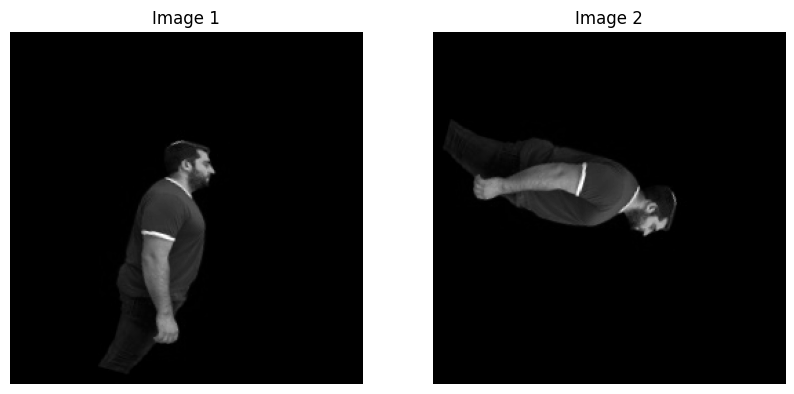

In [ ]:
right,stomach = next(iter(train_loader_2))
stomach = transforms.functional.affine(right,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(right.squeeze(),cmap="gray")
axes[0].set_title('Image 1')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(stomach.squeeze(),cmap="gray")
axes[1].set_title('Image 2')
axes[1].axis('off')

# Show the plot
plt.show()

In [ ]:
loss_2 = train(opt,net_right,train_loader_2,criterion,100,device)

, 0.0225s][1/100] [1/130] Loss = 0.0196
fake tries: 0 percentage = 0.0000, real tries:1 percentage:1.0000, ratio real/fake = 10000000.0000
, 0.4126s][1/100] [31/130] Loss = 0.0304
fake tries: 10 percentage = 0.3226, real tries:21 percentage:0.6774, ratio real/fake = 2.1000
, 0.7787s][1/100] [61/130] Loss = 0.0367
fake tries: 16 percentage = 0.2623, real tries:45 percentage:0.7377, ratio real/fake = 2.8125
, 1.1791s][1/100] [91/130] Loss = 0.0584
fake tries: 19 percentage = 0.2088, real tries:72 percentage:0.7912, ratio real/fake = 3.7895
, 1.2562s][2/100] [1/130] Loss = 0.0190
fake tries: 20 percentage = 0.2062, real tries:77 percentage:0.7938, ratio real/fake = 3.8500
, 1.6150s][2/100] [31/130] Loss = 0.0596
fake tries: 27 percentage = 0.2126, real tries:100 percentage:0.7874, ratio real/fake = 3.7037
, 1.9874s][2/100] [61/130] Loss = 0.0285
fake tries: 36 percentage = 0.2293, real tries:121 percentage:0.7707, ratio real/fake = 3.3611
, 2.3804s][2/100] [91/130] Loss = 0.0321
fake trie

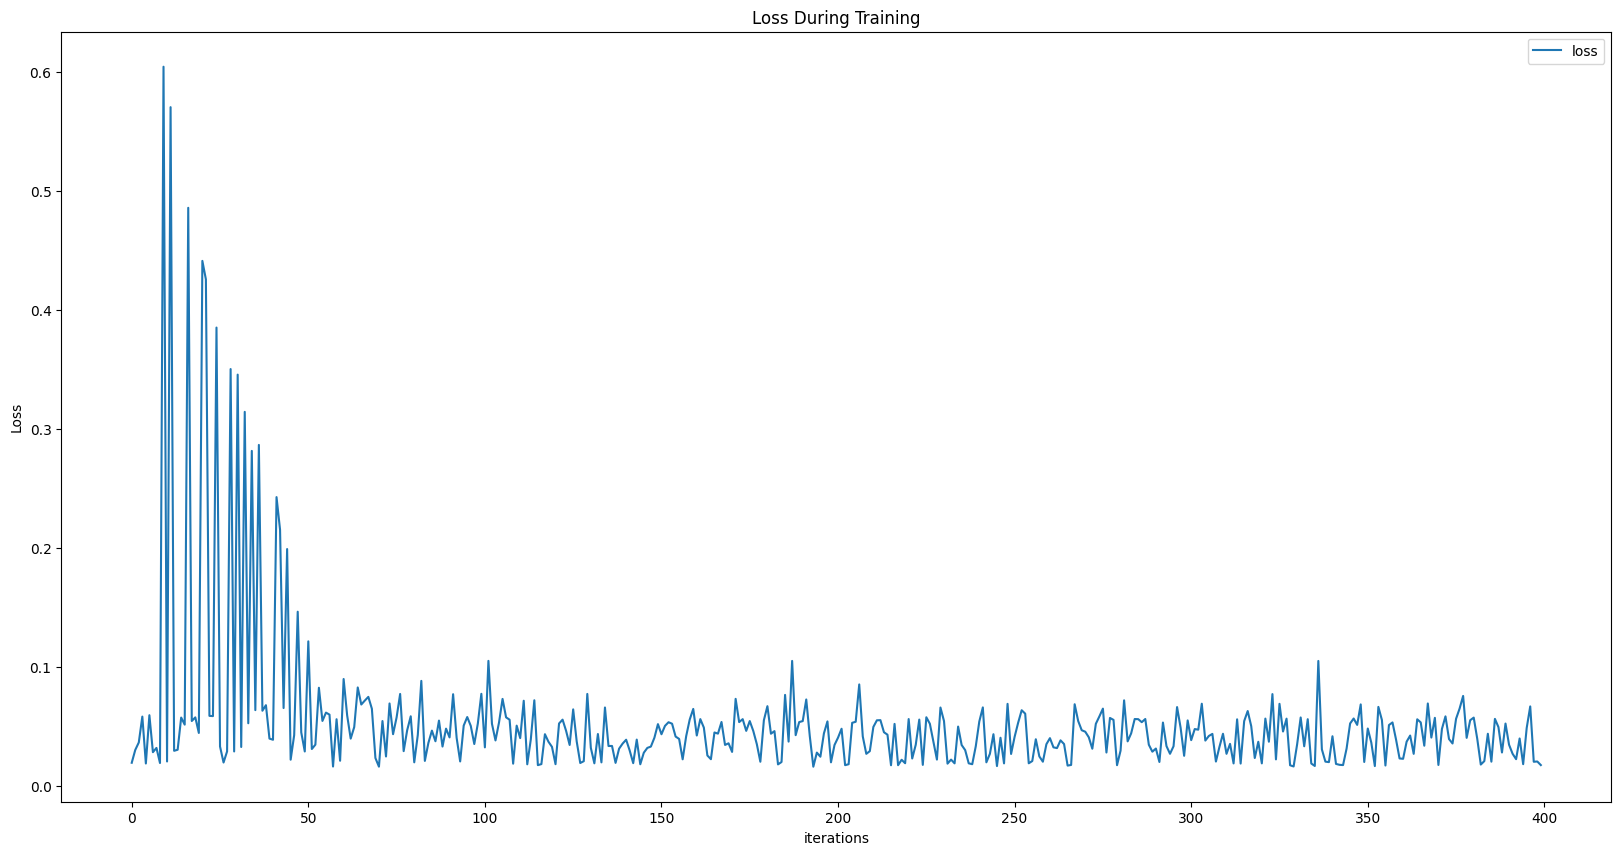

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Loss During Training")
plt.plot(loss_2,label="loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([[ 1.5136,  0.0423, -0.3142,  0.9998, -0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[ 1.51358342  0.04225931 -0.31423274  0.9997623  -0.01641807]



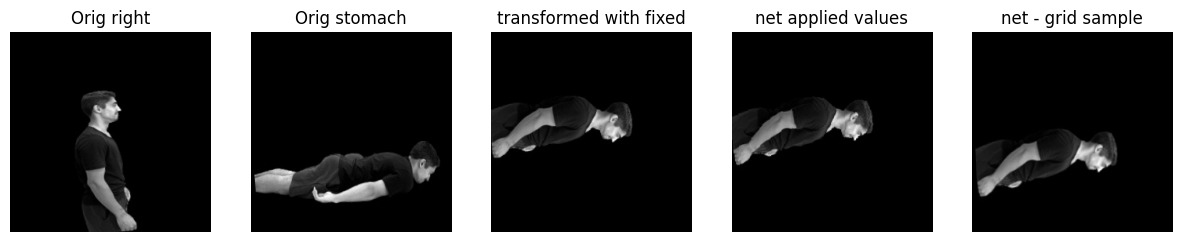

In [ ]:
right,stomach = next(iter(train_loader_2))
pic_target = transforms.functional.affine(right,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Display the first image on the left subplot
axes[0].imshow(right.squeeze(),cmap="gray")
axes[0].set_title('Orig right')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(stomach.squeeze(),cmap="gray")
axes[1].set_title('Orig stomach')
axes[1].axis('off')

# Show the plot
out = net_right(right.to(device))
print(out[0])
array = out[0].cpu().detach().numpy()[0].astype('float')
print(array)
print()
out_transform = transforms.functional.affine(right,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))
axes[2].imshow(pic_target.squeeze(),cmap="gray")
axes[2].set_title('transformed with fixed')
axes[2].axis('off')

axes[3].imshow(out_transform.squeeze().cpu().detach().numpy(),cmap="gray")
axes[3].set_title('net applied values')
axes[3].axis('off')

axes[4].imshow(torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy(),cmap="gray")
axes[4].set_title('net - grid sample')
axes[4].axis('off')


plt.show()

tensor([1.5708, 0.0000, 0.0000, 1.0000, 0.0000])
tensor([[ 1.5140,  0.0423, -0.3144,  1.0000, -0.0164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
[ 1.51401532  0.04225151 -0.31438166  1.00003564 -0.0164027 ]



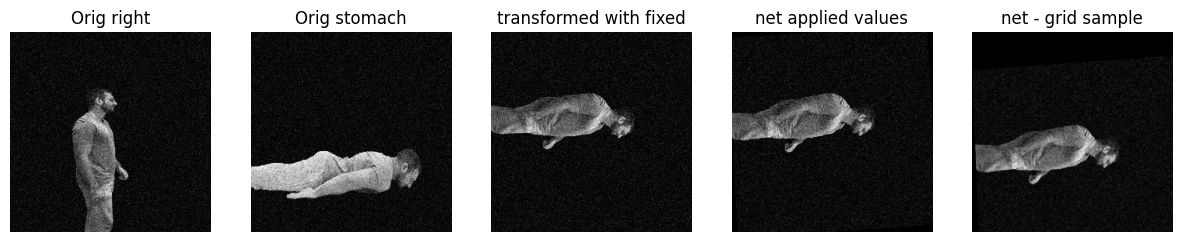

In [ ]:
right,stomach = next(iter(test_loader_2))
pic_target = transforms.functional.affine(right,90,[0,0],1,0)
target = torch.tensor([torch.deg2rad(torch.tensor(90)).item(),0,0,1,0])
print(target)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Display the first image on the left subplot
axes[0].imshow(right.squeeze(),cmap="gray")
axes[0].set_title('Orig right')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(stomach.squeeze(),cmap="gray")
axes[1].set_title('Orig stomach')
axes[1].axis('off')

# Show the plot
out = net_right(right.to(device))
print(out[0])
array = out[0].cpu().detach().numpy()[0].astype('float')
print(array)
print()
out_transform = transforms.functional.affine(right,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))
axes[2].imshow(pic_target.squeeze(),cmap="gray")
axes[2].set_title('transformed with fixed')
axes[2].axis('off')

axes[3].imshow(out_transform.squeeze().cpu().detach().numpy(),cmap="gray")
axes[3].set_title('net applied values')
axes[3].axis('off')

axes[4].imshow(torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy(),cmap="gray")
axes[4].set_title('net - grid sample')
axes[4].axis('off')


plt.show()

In [ ]:
mse_fix_avg = 0
mse_net_avg = 0
mse_grid_avg = 0
ncc_fix_avg = 0
ncc_net_avg = 0
ncc_grid_avg = 0
leng = len(test_loader_2)
for right,stomach in test_loader_2:
  stomach_np = stomach.squeeze().cpu().numpy()

  pic_target = transforms.functional.affine(right,90,[0,0],1,0)
  fixed_np = pic_target.squeeze().cpu().numpy()

  out = net_right(right.to(device))
  array = out[0].cpu().detach().numpy()[0].astype('float')
  out_transform = transforms.functional.affine(right,float(np.rad2deg(array[0])),[float(array[1]),float(array[2])],float(np.abs(array[3])),float(np.rad2deg(array[4])))

  net_np = out_transform.squeeze().cpu().detach().numpy()
  grid_np = torch.flip(out[1].squeeze().cpu().detach(),[1]).numpy()

  mse_fix_avg += mean_squared_error(stomach_np,fixed_np)
  mse_net_avg += mean_squared_error(stomach_np,net_np)
  mse_grid_avg += mean_squared_error(stomach_np,grid_np)
  ncc_fix_avg += normalized_cross_correlation(stomach_np,fixed_np)
  ncc_net_avg += normalized_cross_correlation(stomach_np,net_np)
  ncc_grid_avg += normalized_cross_correlation(stomach_np,grid_np)
print("MSE - need lower, NCC - need higher")
print(f"AVG Difference between fixed transformation and back image: MSE = {mse_fix_avg/leng:.5f} NCC = {ncc_fix_avg/leng:.5f}")
print(f"AVG Difference between net transformation and back image: MSE = {mse_net_avg/leng:.5f} NCC = {ncc_net_avg/leng:.5f}")
print(f"AVG Difference between grid transformation and back image: MSE = {mse_grid_avg/leng:.5f} NCC = {ncc_grid_avg/leng:.5f}")

MSE - need lower, NCC - need higher
AVG Difference between fixed transformation and back image: MSE = 0.06574 NCC = -0.07996
AVG Difference between net transformation and back image: MSE = 0.06588 NCC = -0.07815
AVG Difference between grid transformation and back image: MSE = 0.04415 NCC = 0.30625


In [ ]:
torch.save(net_right,'/content/drive/MyDrive/final_project_data/right_stomach_transformation.pth')

In [ ]:
torch.save(net_left,'/content/drive/MyDrive/final_project_data/left_back_transformation.pth')